In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX

# =============================
# 1. LOAD DATA
# =============================

df = pd.read_csv('./Task1/Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)
df = df.asfreq('M')
df['Prices'] = df['Prices'].astype(float)


      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0


C:\Users\athil\AppData\Local\Temp\ipykernel_22672\1389423342.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])
C:\Users\athil\AppData\Local\Temp\ipykernel_22672\1389423342.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')


In [6]:
# =============================
# 2. ADD SEASONALITY (Fourier terms)
# =============================

def add_fourier_terms(df, period=12, K=3):
    t = np.arange(len(df))
    for k in range(1, K+1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return df

df = add_fourier_terms(df)
exog = df.drop(columns=['Prices'])

In [12]:
# =============================
# 3. FIT MODEL
# =============================

model = SARIMAX(
    df['Prices'],
    order=(1,0,0),
    seasonal_order=(0,0,0,0),
    exog=exog,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                 Prices   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  -4.661
Date:                Tue, 02 Dec 2025   AIC                             25.322
Time:                        17:28:00   BIC                             40.123
Sample:                    10-31-2020   HQIC                            30.891
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1          0.6790      0.106      6.436      0.000       0.472       0.886
cos_1         -0.0420      0.116     -0.360      0.719      -0.270       0.186
sin_2         -0.0510      0.060     -0.846      0.3

c:\Users\athil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# =============================
# 4. FUNCTION: PREDICT PRICE FOR ANY DATE
# =============================

def estimate_price(query_date: str):
    qdate = pd.to_datetime(query_date)

    # If in historical data → interpolate
    if qdate <= df.index.max():
        idx = np.searchsorted(df.index.values, np.datetime64(qdate))
        if idx == 0:
            return float(df.iloc[0]['Prices'])

        before = df.iloc[idx - 1]
        after = df.iloc[idx] if idx < len(df) else before

        total_days = (after.name - before.name).days
        passed_days = (qdate - before.name).days

        return float(
            before['Prices'] + 
            (after['Prices'] - before['Prices']) 
            * (passed_days / total_days)
        )

    # If future → forecast
    periods = (qdate.to_period('M') - df.index[-1].to_period('M')).n
    future_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(),
                                 periods=periods,
                                 freq='M')

    future_df = pd.DataFrame(index=future_index)
    future_df = add_fourier_terms(future_df)

    forecast = results.get_forecast(
        steps=periods,
        exog=future_df
    )

    value = forecast.predicted_mean.iloc[-1]
    return float(value)


In [9]:
# =============================
# 5. 1 YEAR FUTURE FORECAST
# =============================

future_dates = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')
future = pd.DataFrame(index=future_dates)
future = add_fourier_terms(future)

forecast = results.get_forecast(steps=12, exog=future)
future['Forecast_Price'] = forecast.predicted_mean
ci = forecast.conf_int()
future['Lower'] = ci.iloc[:, 0]
future['Upper'] = ci.iloc[:, 1]


C:\Users\athil\AppData\Local\Temp\ipykernel_22672\2441178176.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')


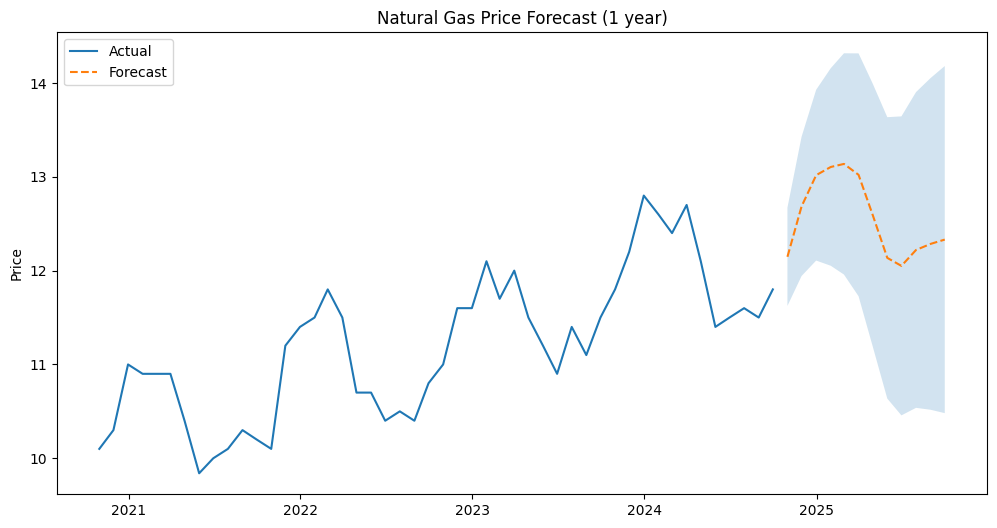

In [10]:
# =============================
# 6. VISUALIZATION
# =============================

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Prices'], label='Actual')
plt.plot(future.index, future['Forecast_Price'], linestyle='--', label='Forecast')
plt.fill_between(future.index, future['Lower'], future['Upper'], alpha=0.2)
plt.title("Natural Gas Price Forecast (1 year)")
plt.ylabel("Price")
plt.legend()
plt.show()



In [11]:
# =============================
# 7. SAMPLE USAGE
# =============================
print("Estimated price on 2023-06-15:", estimate_price("2023-06-15"))
print("Estimated price on 2025-07-30:", estimate_price("2025-07-30"))
print("\nFuture Forecast:")
print(future)

Estimated price on 2023-06-15: 11.05
Estimated price on 2025-07-30: 12.220136889700726

Future Forecast:
                   sin_1         cos_1         sin_2  cos_2         sin_3  \
2024-10-31  0.000000e+00  1.000000e+00  0.000000e+00    1.0  0.000000e+00   
2024-11-30  5.000000e-01  8.660254e-01  8.660254e-01    0.5  1.000000e+00   
2024-12-31  8.660254e-01  5.000000e-01  8.660254e-01   -0.5  1.224647e-16   
2025-01-31  1.000000e+00  6.123234e-17  1.224647e-16   -1.0 -1.000000e+00   
2025-02-28  8.660254e-01 -5.000000e-01 -8.660254e-01   -0.5 -2.449294e-16   
2025-03-31  5.000000e-01 -8.660254e-01 -8.660254e-01    0.5  1.000000e+00   
2025-04-30  1.224647e-16 -1.000000e+00 -2.449294e-16    1.0  3.673940e-16   
2025-05-31 -5.000000e-01 -8.660254e-01  8.660254e-01    0.5 -1.000000e+00   
2025-06-30 -8.660254e-01 -5.000000e-01  8.660254e-01   -0.5 -4.898587e-16   
2025-07-31 -1.000000e+00 -1.836970e-16  3.673940e-16   -1.0  1.000000e+00   
2025-08-31 -8.660254e-01  5.000000e-01 -8.660254

C:\Users\athil\AppData\Local\Temp\ipykernel_22672\3529152564.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(),


In [ ]:
# Since the dataset provides monthly values sampled at month-end, 
# the data does not contain daily, weekend, or holiday-level granularity.
# Therefore, no explicit filtering for holidays or weekends is necessary. 
# The model operates purely on a monthly frequency and automatically ignores those effects.”